### Predicting ratings

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import itertools
import torch
torch.use_deterministic_algorithms(True)

In [2]:
data = pd.read_csv("../dat/data_clean.csv")

C:\Users\Balint\miniconda3\envs\d2l\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273543 entries, 0 to 273542
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   tconst                       273543 non-null  object 
 1   titleType                    273543 non-null  object 
 2   primaryTitle                 273543 non-null  object 
 3   originalTitle                273543 non-null  object 
 4   isAdult                      273543 non-null  int64  
 5   startYear                    273543 non-null  object 
 6   endYear                      273543 non-null  object 
 7   runtimeMinutes               273543 non-null  object 
 8   genres                       273543 non-null  object 
 9   averageRating                273543 non-null  float64
 10  numVotes                     273543 non-null  int64  
 11  Budget                       49881 non-null   float64
 12  Gross US & Canada            18982 non-null   float64
 13 

In [4]:
data["Critic reviews"] = data["Critic reviews"].fillna(0)
data["User reviews"] = data["User reviews"].fillna(0)

data["isAdult2"] = data.apply(lambda row: int("Adult" in row["genres"]), axis=1)
print(len(data[data["isAdult"] != data["isAdult2"]]))  # We use the one based on the genres

# tconst was only required for joins
# titleType is only films for us, we filtered them
# we do not use the titles as predictors
# endYear is None for all films
# isAdult will be added back in a consistent format later on

# We drop writers and directors. These are interesting features,
# but having them as binary columns would be infeasible.
data = data.drop(columns=[
    "tconst", "titleType", "primaryTitle", "originalTitle", "endYear",
    "isAdult", "isAdult2", "Gross US & Canada", "Opening weekend US & Canada",
    "writers", "directors"])
data = data.dropna()

318


In [5]:
genre_list = data["genres"].unique().tolist()
for i, entry in enumerate(genre_list):
    genre_list[i] = entry.split(",")

genre_set = set(itertools.chain(*genre_list))
print(genre_set)

{'Fantasy', 'Musical', 'Action', 'Drama', 'Western', 'Animation', 'Adventure', 'Film-Noir', 'War', 'Documentary', 'History', 'Romance', 'Music', 'Crime', 'Biography', 'Sci-Fi', 'Comedy', 'Family', 'Thriller', 'Horror', 'Sport', 'Mystery', 'News'}


In [6]:
# News - History - Biography - Documentary --> Documentary
# Film-Noir - Crime --> Crime
# Western - Action --> Action
genre_set.difference_update(["News", "History", "Biography", "Film-Noir", "Western"])
transformation_dict = {
    "Documentary":  ["News", "History", "Biography", "Documentary"],
    "Crime": ["Film-Noir", "Crime"],
    "Action": ["Western", "Action"]
}
for genre in genre_set:
    print(genre, end=" ")
    if genre not in transformation_dict:
        transformation_dict[genre] = [genre]
    data[f"is{genre}"] = data.apply(lambda row: int(any(g in row["genres"] for g in transformation_dict[genre])), axis=1)

Fantasy Musical Action Drama Animation Adventure War Documentary Romance Music Crime Sci-Fi Comedy Family Thriller Horror Sport Mystery 

In [7]:
results = []
for genre in genre_set:
    results.append(data[f"is{genre}"].sum())

sum_results = sum(results)
for genre in genre_set:
    print(genre, data[f"is{genre}"].sum() / sum_results * 100, "% - ", data[f"is{genre}"].sum())

Fantasy 2.8179712126390943 % -  742
Musical 0.5089058524173028 % -  134
Action 9.843910219892901 % -  2592
Drama 21.920929702631877 % -  5772
Animation 1.993847556112567 % -  525
Adventure 6.7107212031445815 % -  1767
War 0.8658995100831719 % -  228
Documentary 4.564961452280582 % -  1202
Romance 6.737305837226083 % -  1774
Music 1.7659792639854164 % -  465
Crime 7.569025103490183 % -  1993
Sci-Fi 2.529338042611371 % -  666
Comedy 14.488625574417988 % -  3815
Family 2.2938741407466483 % -  604
Thriller 6.63096730090008 % -  1746
Horror 4.348486574759789 % -  1145
Sport 0.9190687782461737 % -  242
Mystery 3.4901826744141884 % -  919


In [8]:
# Genres are added as binary predictors, thus the genres column is no longer used.
data = data.drop(columns=["genres"])  # "isMusical", "isFilm-Noir", "isNews", "isSport", "genres"])

def unrated_to_not_rated(row):
    if row["Rating"] == "Unrated":
        return "Not Rated"
    else:
        return row["Rating"]

data["Rating"] = data.apply(unrated_to_not_rated, axis=1)

In [9]:
data[f"isRated"] = data.apply(lambda row: int(row["Rating"] != "Not Rated"), axis=1)

In [10]:
data = data.drop(columns=["Rating"])

In [11]:
def clean_unknowns(row, column):
    if row[column] == "\\N":
        return None
    else:
        return row[column]

def clean_reviews(row, column):
    if isinstance(row[column], str) and "K" in row[column]:
        if "." in row[column]:
            return int(row[column][:-3]) * 1000 + int(row[column][-2]) * 100
        else:
            return int(row[column][:-1]) * 1000
    else:
        return row[column]

data["startYear"] = data.apply(lambda row: clean_unknowns(row, "startYear"), axis=1)
data["runtimeMinutes"] = data.apply(lambda row: clean_unknowns(row, "runtimeMinutes"), axis=1)
data["User reviews"] = data.apply(lambda row: clean_reviews(row, "User reviews"), axis=1)
data["Critic reviews"] = data.apply(lambda row: clean_reviews(row, "Critic reviews"), axis=1)

for column in ["startYear", "runtimeMinutes", "User reviews", "Critic reviews"]:
    data[column] = pd.to_numeric(data[column])



In [23]:
print("All features present:")
filtered = data.dropna()
filtered.reset_index(inplace=True)
filtered = filtered.drop(columns=["index"])
print(len(filtered))

All features present:
10714


In [24]:
filtered.corr().style.background_gradient(cmap='coolwarm')

,startYear,runtimeMinutes,averageRating,numVotes,Budget,Gross worldwide,Critic reviews,User reviews,isFantasy,isMusical,isAction,isDrama,isAnimation,isAdventure,isWar,isDocumentary,isRomance,isMusic,isCrime,isSci-Fi,isComedy,isFamily,isThriller,isHorror,isSport,isMystery,isRated
startYear,1.000000,-0.035866,-0.201522,0.000240,-0.023247,-0.057779,0.193535,0.059286,-0.007435,-0.079189,0.062450,-0.023440,0.061377,0.014030,-0.055095,0.076020,-0.072984,-0.049175,-0.043072,-0.021172,-0.029636,-0.006475,0.037106,0.010315,-0.001944,-0.012530,-0.166430
runtimeMinutes,-0.035866,1.000000,0.327356,0.263119,0.281783,0.222601,0.197618,0.263035,-0.007126,0.066672,0.157000,0.251510,-0.188850,0.023855,0.098452,0.132065,0.037874,0.042845,0.034734,0.013944,-0.198908,-0.076188,-0.017890,-0.161497,0.023717,-0.004244,-0.059407
averageRating,-0.201522,0.327356,1.000000,0.373765,0.094344,0.207771,0.320645,0.259345,-0.050636,0.017918,-0.088066,0.259717,0.016830,-0.027122,0.073410,0.203175,0.017810,0.039827,0.033494,-0.039149,-0.116203,-0.063889,-0.086492,-0.194478,0.030757,-0.005072,0.009748
numVotes,0.000240,0.263119,0.373765,1.000000,0.484440,0.604826,0.632424,0.748153,0.057248,-0.020421,0.143913,-0.053881,0.032153,0.174233,-0.003589,-0.039296,-0.062362,-0.039960,0.012083,0.161098,-0.058298,-0.019788,0.008170,-0.030451,-0.020418,0.026221,0.181424
Budget,-0.023247,0.281783,0.094344,0.484440,1.000000,0.618972,0.470934,0.493993,0.122698,-0.002538,0.288313,-0.180196,0.156256,0.412964,-0.018468,-0.066076,-0.074949,-0.046011,-0.030025,0.187617,0.001382,0.073103,-0.024849,-0.114956,-0.014845,-0.035106,0.265037
Gross worldwide,-0.057779,0.222601,0.207771,0.604826,0.618972,1.000000,0.447165,0.528583,0.085165,-0.004438,0.157823,-0.143340,0.150514,0.302571,-0.022194,-0.054449,-0.046415,-0.024488,-0.057878,0.120041,0.004148,0.059786,-0.022244,-0.056392,-0.023446,-0.029502,0.165175
Critic reviews,0.193535,0.197618,0.320645,0.632424,0.470934,0.447165,1.000000,0.635358,0.089842,-0.023878,0.153225,-0.038121,0.020177,0.174983,-0.024894,-0.017815,-0.080864,-0.044073,-0.004029,0.187049,-0.093213,-0.051485,0.045821,0.107734,-0.043205,0.084005,0.252920
User reviews,0.059286,0.263035,0.259345,0.748153,0.493993,0.528583,0.635358,1.000000,0.084869,-0.001391,0.168931,-0.054181,-0.015183,0.178414,-0.005661,-0.051012,-0.071699,-0.027985,-0.015094,0.187933,-0.102268,-0.031068,0.029438,0.052397,-0.031435,0.054678,0.181563
isFantasy,-0.007435,-0.007126,-0.050636,0.057248,0.122698,0.085165,0.089842,0.084869,1.000000,-0.004235,0.011581,-0.111114,-0.012532,0.094728,-0.037676,-0.089979,-0.050301,-0.032844,-0.113395,-0.050434,-0.011676,0.129378,-0.097374,0.086511,-0.036519,-0.027103,0.042758
isMusical,-0.079189,0.066672,0.017918,-0.020421,-0.002538,-0.004438,-0.023878,-0.001391,-0.004235,1.000000,-0.057693,-0.001984,-0.013874,-0.045488,-0.010775,-0.024039,0.042507,0.528353,-0.030058,-0.025495,0.035580,0.001623,-0.049623,-0.019900,-0.011456,-0.034472,-0.010384


In [25]:
np.random.seed(42)
test_indices = np.random.choice(len(filtered), replace=False, size=int(len(filtered) / 10))

print(filtered.index)

test_set = filtered.iloc[test_indices]
test_set, test_targets = test_set.drop("averageRating", axis=1).to_numpy(), test_set["averageRating"].to_numpy()
train_set = filtered.iloc[~filtered.index.isin(test_indices)]
train_set, train_targets = train_set.drop("averageRating", axis=1).to_numpy(), train_set["averageRating"].to_numpy()

print(test_set.shape, train_set.shape)

RangeIndex(start=0, stop=10714, step=1)
(1071, 26) (9643, 26)


In [26]:
filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10714 entries, 0 to 10713
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   startYear        10714 non-null  int64  
 1   runtimeMinutes   10714 non-null  float64
 2   averageRating    10714 non-null  float64
 3   numVotes         10714 non-null  int64  
 4   Budget           10714 non-null  float64
 5   Gross worldwide  10714 non-null  float64
 6   Critic reviews   10714 non-null  float64
 7   User reviews     10714 non-null  float64
 8   isFantasy        10714 non-null  int64  
 9   isMusical        10714 non-null  int64  
 10  isAction         10714 non-null  int64  
 11  isDrama          10714 non-null  int64  
 12  isAnimation      10714 non-null  int64  
 13  isAdventure      10714 non-null  int64  
 14  isWar            10714 non-null  int64  
 15  isDocumentary    10714 non-null  int64  
 16  isRomance        10714 non-null  int64  
 17  isMusic     

### Logistic Regression, MAE

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor

test_set = torch.from_numpy(test_set)
test_set_normalized = (test_set - test_set.mean(dim=0, keepdims=True)) / test_set.std(dim=0, keepdims=True)
test_set_normalized = torch.nan_to_num(test_set_normalized, nan=0)
test_targets = torch.from_numpy(test_targets)

train_set = torch.from_numpy(train_set)
train_set_normalized = (train_set - train_set.mean(dim=0, keepdims=True)) / train_set.std(dim=0, keepdims=True)
train_set_normalized = torch.nan_to_num(train_set_normalized, nan=0)
train_targets = torch.from_numpy(train_targets)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x)) * 9 + 1

In [30]:


# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

torch.manual_seed(1337)
model = Model()

opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
best_pred_lr = None


epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-6:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_lr = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0764], dtype=torch.float64)
Epoch 100, Training Loss (MAE) 1.2382, Validation Loss (MAE) 1.2355

tensor([0.0634], dtype=torch.float64)
Epoch 200, Training Loss (MAE) 1.0504, Validation Loss (MAE) 1.0429

tensor([0.0488], dtype=torch.float64)
Epoch 300, Training Loss (MAE) 0.8983, Validation Loss (MAE) 0.8894

tensor([0.0346], dtype=torch.float64)
Epoch 400, Training Loss (MAE) 0.7870, Validation Loss (MAE) 0.7783

tensor([0.0229], dtype=torch.float64)
Epoch 500, Training Loss (MAE) 0.7101, Validation Loss (MAE) 0.7034

tensor([0.0135], dtype=torch.float64)
Epoch 600, Training Loss (MAE) 0.6615, Validation Loss (MAE) 0.6574

tensor([0.0076], dtype=torch.float64)
Epoch 700, Training Loss (MAE) 0.6340, Validation Loss (MAE) 0.6318

tensor([0.0045], dtype=torch.float64)
Epoch 800, Training Loss (MAE) 0.6182, Validation Loss (MAE) 0.6186

tensor([0.0023], dtype=torch.float64)
Epoch 900, Training Loss (MAE) 0.6092, Validation Loss (MAE) 0.6111

tensor([0.0014], dtype=torch.float64)

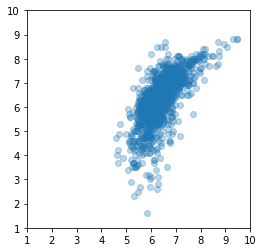

In [31]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Logistic Regression, MSE

In [32]:

loss_fn = nn.MSELoss()
val_loss_fn = nn.L1Loss()
torch.manual_seed(1337)


model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

best_loss = np.inf
epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-6:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (MSE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.3016], dtype=torch.float64)
Epoch 100, Training Loss (MSE) 1.1783, Validation Loss (MAE) 0.8594

tensor([0.0568], dtype=torch.float64)
Epoch 200, Training Loss (MSE) 0.7931, Validation Loss (MAE) 0.6798

tensor([0.0147], dtype=torch.float64)
Epoch 300, Training Loss (MSE) 0.7125, Validation Loss (MAE) 0.6307

tensor([0.0055], dtype=torch.float64)
Epoch 400, Training Loss (MSE) 0.6881, Validation Loss (MAE) 0.6152

tensor([0.0026], dtype=torch.float64)
Epoch 500, Training Loss (MSE) 0.6779, Validation Loss (MAE) 0.6080

tensor([0.0014], dtype=torch.float64)
Epoch 600, Training Loss (MSE) 0.6726, Validation Loss (MAE) 0.6042

tensor([0.0009], dtype=torch.float64)
Epoch 700, Training Loss (MSE) 0.6696, Validation Loss (MAE) 0.6022

tensor([0.0005], dtype=torch.float64)
Epoch 800, Training Loss (MSE) 0.6678, Validation Loss (MAE) 0.6011

tensor([0.0003], dtype=torch.float64)
Epoch 900, Training Loss (MSE) 0.6666, Validation Loss (MAE) 0.6003

tensor([0.0002], dtype=torch.float64)

### Logistic Regression, BCE

In [33]:

test_targets_bce = (test_targets - 1) / 9
train_targets_bce = (train_targets - 1) / 9

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 1, dtype=torch.double)

    def forward(self, x):
        return torch.sigmoid(self.layer1(x))

loss_fn = nn.BCELoss()
val_loss_fn = nn.L1Loss()

best_loss = np.inf

torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.001)

epoch = 0
while model.layer1.weight.grad is None or (
    torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27 >= 1e-4:
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets_bce)
    if epoch % 100 == 99:
        print((torch.norm(model.layer1.weight.grad)**2 + model.layer1.bias.grad**2) / 27)
        print(f"Epoch {epoch + 1}, Training Loss (BCE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze() * 9 + 1, test_targets_bce * 9 + 1)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

tensor([0.0011], dtype=torch.float64)
Epoch 100, Training Loss (BCE) 0.7282, Validation Loss (MAE) 1.4340

tensor([0.0010], dtype=torch.float64)
Epoch 200, Training Loss (BCE) 0.7254, Validation Loss (MAE) 1.4090

tensor([0.0010], dtype=torch.float64)
Epoch 300, Training Loss (BCE) 0.7227, Validation Loss (MAE) 1.3847

tensor([0.0009], dtype=torch.float64)
Epoch 400, Training Loss (BCE) 0.7201, Validation Loss (MAE) 1.3610

tensor([0.0009], dtype=torch.float64)
Epoch 500, Training Loss (BCE) 0.7177, Validation Loss (MAE) 1.3379

tensor([0.0008], dtype=torch.float64)
Epoch 600, Training Loss (BCE) 0.7154, Validation Loss (MAE) 1.3154

tensor([0.0008], dtype=torch.float64)
Epoch 700, Training Loss (BCE) 0.7132, Validation Loss (MAE) 1.2935

tensor([0.0008], dtype=torch.float64)
Epoch 800, Training Loss (BCE) 0.7111, Validation Loss (MAE) 1.2721

tensor([0.0007], dtype=torch.float64)
Epoch 900, Training Loss (BCE) 0.7091, Validation Loss (MAE) 1.2513

tensor([0.0007], dtype=torch.float64)

### ReLU network #2, MAE

In [34]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1

model = Model()
list(model.modules())[1:]

[Linear(in_features=26, out_features=32, bias=True),
 Linear(in_features=32, out_features=1, bias=True)]

In [35]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(26, 32, dtype=torch.double)
        self.layer2 = nn.Linear(32, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
    
        return torch.sigmoid(self.layer2(x)) * 9 + 1


loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.003, weight_decay=1e-2)

epoch = 0
grad_norm = 1
best_loss = np.inf
for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8181, Validation Loss (MAE) 0.8389

Epoch 200, Training Loss (MAE) 0.7440, Validation Loss (MAE) 0.7560

Epoch 300, Training Loss (MAE) 0.7034, Validation Loss (MAE) 0.7122

Epoch 400, Training Loss (MAE) 0.6774, Validation Loss (MAE) 0.6846

Epoch 500, Training Loss (MAE) 0.6597, Validation Loss (MAE) 0.6664

Epoch 600, Training Loss (MAE) 0.6473, Validation Loss (MAE) 0.6540

Epoch 700, Training Loss (MAE) 0.6379, Validation Loss (MAE) 0.6447

Epoch 800, Training Loss (MAE) 0.6307, Validation Loss (MAE) 0.6376

Epoch 900, Training Loss (MAE) 0.6249, Validation Loss (MAE) 0.6313

Epoch 1000, Training Loss (MAE) 0.6200, Validation Loss (MAE) 0.6262

Epoch 1100, Training Loss (MAE) 0.6159, Validation Loss (MAE) 0.6223

Epoch 1200, Training Loss (MAE) 0.6123, Validation Loss (MAE) 0.6188

Epoch 1300, Training Loss (MAE) 0.6090, Validation Loss (MAE) 0.6156

Epoch 1400, Training Loss (MAE) 0.6062, Validation Loss (MAE) 0.6128

Epoch 1500, Training Loss (MA

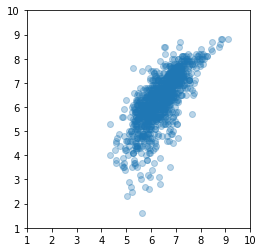

In [36]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### ReLU network #4, MAE

In [38]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
    
        return torch.sigmoid(self.layer4(x)) * 9 + 1


loss_fn = nn.L1Loss()
best_loss = np.inf


torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)

epoch = 0
grad_norm = 1

for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8096, Validation Loss (MAE) 0.8296

Epoch 200, Training Loss (MAE) 0.7853, Validation Loss (MAE) 0.8012

Epoch 300, Training Loss (MAE) 0.7500, Validation Loss (MAE) 0.7581

Epoch 400, Training Loss (MAE) 0.7090, Validation Loss (MAE) 0.7097

Epoch 500, Training Loss (MAE) 0.6721, Validation Loss (MAE) 0.6676

Epoch 600, Training Loss (MAE) 0.6413, Validation Loss (MAE) 0.6378

Epoch 700, Training Loss (MAE) 0.6178, Validation Loss (MAE) 0.6176

Epoch 800, Training Loss (MAE) 0.6008, Validation Loss (MAE) 0.6041

Epoch 900, Training Loss (MAE) 0.5888, Validation Loss (MAE) 0.5932

Epoch 1000, Training Loss (MAE) 0.5807, Validation Loss (MAE) 0.5857

Epoch 1100, Training Loss (MAE) 0.5745, Validation Loss (MAE) 0.5797

Epoch 1200, Training Loss (MAE) 0.5694, Validation Loss (MAE) 0.5749

Epoch 1300, Training Loss (MAE) 0.5653, Validation Loss (MAE) 0.5708

Epoch 1400, Training Loss (MAE) 0.5618, Validation Loss (MAE) 0.5673

Epoch 1500, Training Loss (MA

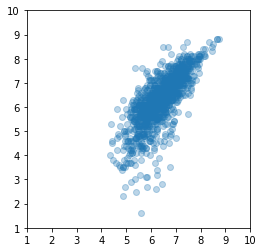

In [39]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

In [42]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.hidden_dim = 32
        
        self.layer1 = nn.Linear(26, self.hidden_dim, dtype=torch.double)
        self.layer2 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer3 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer4 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer5 = nn.Linear(self.hidden_dim, self.hidden_dim, dtype=torch.double)
        self.layer6 = nn.Linear(self.hidden_dim, 1, dtype=torch.double)
    
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = F.relu(self.layer5(x))
    
        return torch.sigmoid(self.layer6(x)) * 9 + 1

loss_fn = nn.L1Loss()
torch.manual_seed(1337)
model = Model()
opt = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=1e-2)

epoch = 0
grad_norm = 1
pred = None 
best_loss = np.inf


for epoch in range(10000):
    pred = model(train_set_normalized)
    loss = loss_fn(pred.squeeze(), train_targets)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1}, Training Loss (MAE) {loss.item():.4f}", end=", ")
        with torch.no_grad():
            pred = model(test_set_normalized)
            val_loss = loss_fn(pred.squeeze(), test_targets)
            print(f"Validation Loss (MAE) {val_loss.item():.4f}")
            if val_loss.item() < best_loss:
                best_loss = val_loss.item()
                best_pred_relu = pred
            
        print()

    opt.zero_grad()
    loss.backward()
    opt.step()
    epoch += 1

with torch.no_grad():
    pred = model(test_set_normalized)
    val_loss = val_loss_fn(pred.squeeze(), test_targets)
    print(f"Final Validation Loss (MAE) {val_loss.item():.4f}")
    print(f"Best Validation Loss (MAE) {best_loss:.4f}")

Epoch 100, Training Loss (MAE) 0.8284, Validation Loss (MAE) 0.8539

Epoch 200, Training Loss (MAE) 0.8245, Validation Loss (MAE) 0.8493

Epoch 300, Training Loss (MAE) 0.8155, Validation Loss (MAE) 0.8389

Epoch 400, Training Loss (MAE) 0.7761, Validation Loss (MAE) 0.7936

Epoch 500, Training Loss (MAE) 0.6548, Validation Loss (MAE) 0.6542

Epoch 600, Training Loss (MAE) 0.5936, Validation Loss (MAE) 0.6001

Epoch 700, Training Loss (MAE) 0.5738, Validation Loss (MAE) 0.5789

Epoch 800, Training Loss (MAE) 0.5627, Validation Loss (MAE) 0.5667

Epoch 900, Training Loss (MAE) 0.5533, Validation Loss (MAE) 0.5578

Epoch 1000, Training Loss (MAE) 0.5462, Validation Loss (MAE) 0.5519

Epoch 1100, Training Loss (MAE) 0.5403, Validation Loss (MAE) 0.5479

Epoch 1200, Training Loss (MAE) 0.5352, Validation Loss (MAE) 0.5444

Epoch 1300, Training Loss (MAE) 0.5326, Validation Loss (MAE) 0.5424

Epoch 1400, Training Loss (MAE) 0.5315, Validation Loss (MAE) 0.5425

Epoch 1500, Training Loss (MA

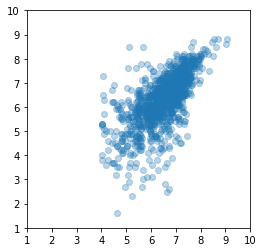

In [ ]:
plt.figure(figsize=(4, 4))
plt.xlim(1, 10)
plt.xticks(range(1, 11))
plt.ylim(1, 10)
plt.scatter(pred, test_targets, alpha=.3)

### Linear Regression, Transformed Outputs

In [ ]:
filtered[filtered["averageRating"] <= 1.3]  # we can use inverse formula
test_targets_inv = -torch.log(9 / (test_targets - 1) - 1)
train_targets_inv = -torch.log(9 / (train_targets - 1) - 1)
train_targets_inv.min(), train_targets_inv.max()

(tensor(-2.1972, dtype=torch.float64), tensor(1.8718, dtype=torch.float64))

In [ ]:
opt_weights = torch.linalg.pinv(train_set) @ train_targets_inv
transformed_preds = test_set @ opt_weights
preds = 9 * 1 / (1 + torch.exp(-transformed_preds)) + 1
((test_targets - preds)**2).mean()

tensor(0.7431, dtype=torch.float64)

### Save the data for plot

In [ ]:
x1 = best_pred_lr.squeeze().numpy()
x2 = best_pred_relu.squeeze().numpy()
y = test_targets.squeeze().numpy()

# np.save("../dat/data_fig1/pred_lr.npy", x1)
# np.save("../dat/data_fig1/pred_relu.npy", x2)
# np.save("../dat/data_fig1/true_ratings.npy", y)